<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_3_ML4HS_UC2023_MNIST_classification_autoencoder_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 116765370.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68322444.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35462472.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13174639.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Latent space comparison
- Classification models
- Autoencoders
- PCA?

In this exercise we will try to visualize the latent representation space of a simple delse neural network.

As a second step, we will write the PCA from scratch in pytorch and then compare the two methods.

In [ ]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self,fv_dim = 2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.feature_vector = nn.Linear(64, fv_dim)
        self.classifier = nn.Linear(fv_dim, 10)

        self.act = nn.ELU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.feature_vector(x))
        x = self.classifier(x)
        return x
    def get_fv(self,x):

        x = x.view(x.size(0), -1)  # Flatten the input image
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.feature_vector(x))

        return x




# Initialize the model
model = Net(fv_dim = 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# CLASSIFICATION
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    print("epoch : ",epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        reg = 0.00001 * torch.sum(model.fc1.weight.abs())
        loss = loss + 2* reg # now reg
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss / 1000}')
            running_loss = 0.0

print('Training finished.')



epoch :  0
Epoch: 1, Batch: 1, Loss: 0.00236637020111084
epoch :  1
Epoch: 2, Batch: 1, Loss: 0.001150009036064148
epoch :  2
Epoch: 3, Batch: 1, Loss: 0.0008646495938301087
epoch :  3
Epoch: 4, Batch: 1, Loss: 0.000882722020149231
epoch :  4
Epoch: 5, Batch: 1, Loss: 0.0007852207422256469
epoch :  5
Epoch: 6, Batch: 1, Loss: 0.0005884662866592407
epoch :  6
Epoch: 7, Batch: 1, Loss: 0.0007174990177154541
epoch :  7
Epoch: 8, Batch: 1, Loss: 0.0005796977877616882
epoch :  8
Epoch: 9, Batch: 1, Loss: 0.0004785618484020233
epoch :  9
Epoch: 10, Batch: 1, Loss: 0.00035093218088150024
epoch :  10
Epoch: 11, Batch: 1, Loss: 0.00041930261254310606
epoch :  11
Epoch: 12, Batch: 1, Loss: 0.0004690914154052734
epoch :  12
Epoch: 13, Batch: 1, Loss: 0.0005149608850479126
epoch :  13
Epoch: 14, Batch: 1, Loss: 0.0003856464624404907
epoch :  14
Epoch: 15, Batch: 1, Loss: 0.0003719731569290161
Training finished.


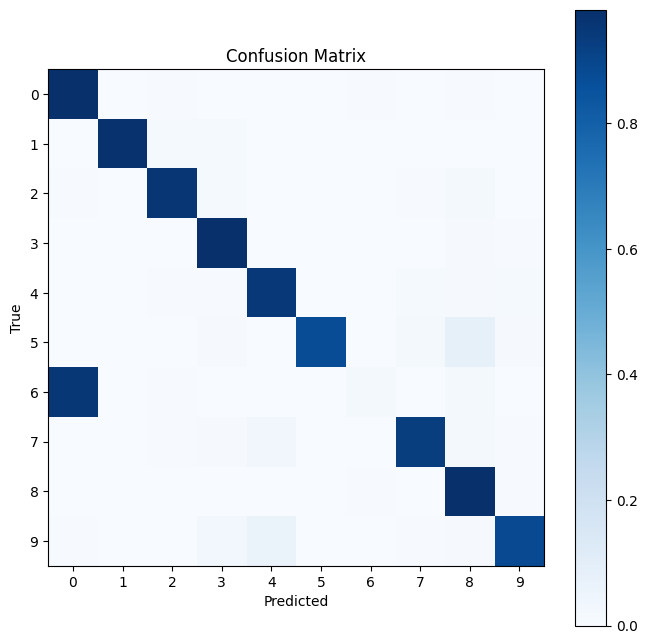

In [ ]:
#Classification
## Evaluate the model on the test set
model.eval()
test_labels = []
predicted_labels = []
test_latent = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        z = model.get_fv(images)
        _, predicted = torch.max(outputs.data, 1)
        test_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        test_latent.extend(z.numpy())

test_latent = np.array(test_latent)
# Plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels, normalize="true")
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

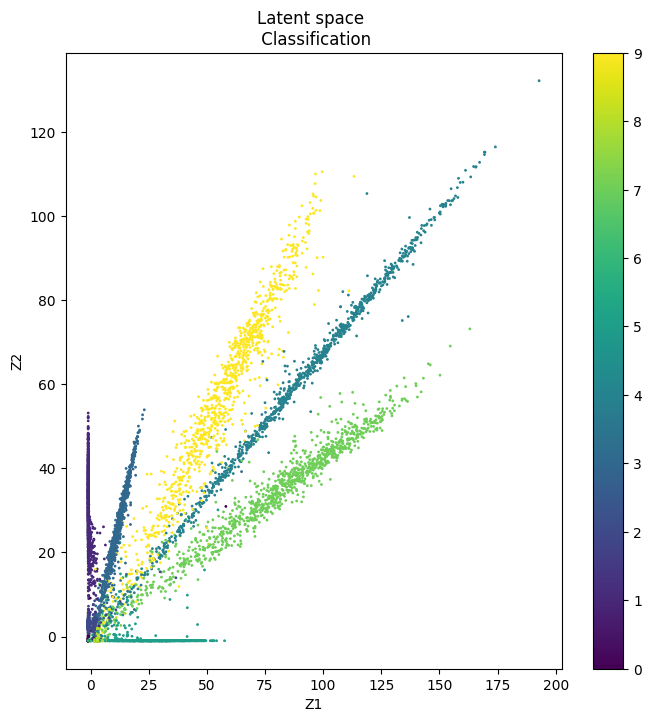

In [ ]:
# Plot the latent  space
f,ax = plt.subplots(1,figsize=(8, 8))

plt.scatter(test_latent[:,0], test_latent[:,1], c=test_labels,  s = 1)
plt.title('Latent space \n Classification')
plt.colorbar()

plt.xlabel('Z1')
plt.ylabel('Z2')
plt.show()

In [ ]:
w = model.fc1.weight.detach().numpy().reshape(128,28,28)

In [ ]:
stacked_w = np.zeros((16*28,8*28))
k=0
for i in range(16):
  for j in range(8):
    start_x = 28*i
    end_x = 28*(i+1)
    start_y = 28*j
    end_y = 28*(j+1)
    stacked_w[start_x:end_x, start_y:end_y,] = w[k]
    k = k+1

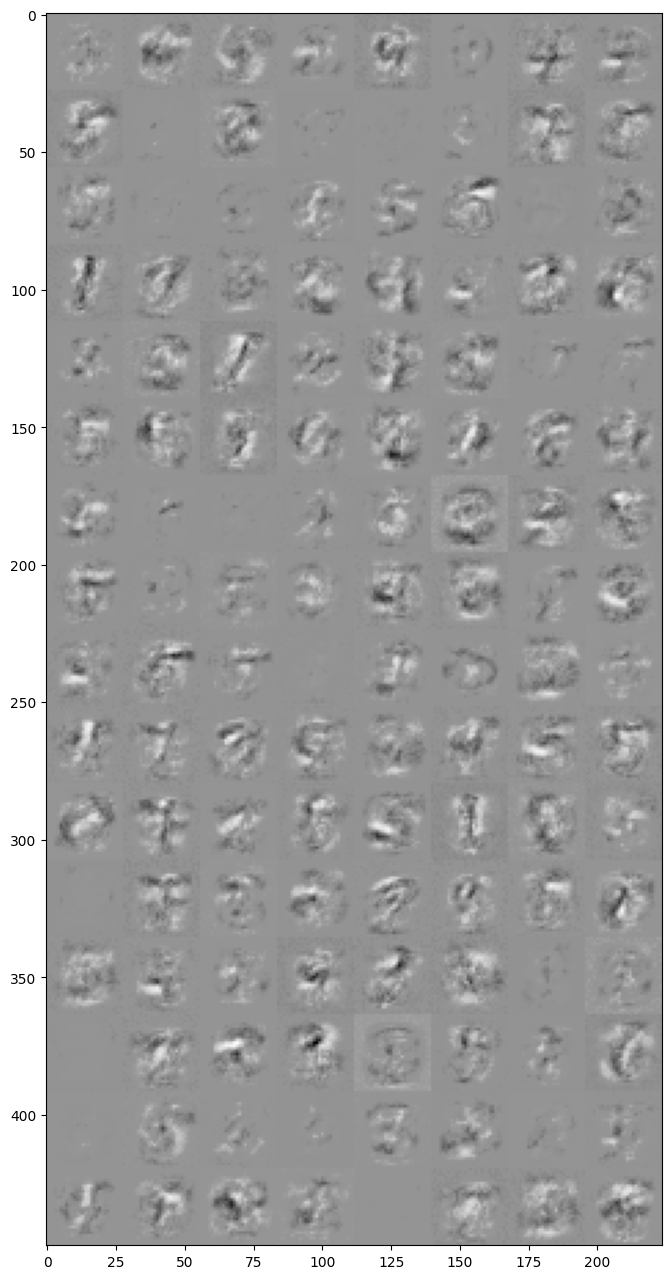

In [ ]:
f,ax = plt.subplots(1,figsize=(8,16))
ax.imshow(stacked_w,cmap="Greys")

In [ ]:
# Autoencoders?
# Define the neural network model
class Autoencoder(nn.Module):
    def __init__(self,latent_dim = 4):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.feature_vector = nn.Linear(64, latent_dim)
        self.decoder1 = nn.Linear(latent_dim, 64)
        self.decoder2 = nn.Linear(64, 128)
        self.decoder3 = nn.Linear(128, 28*28)

        self.act = nn.ELU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.feature_vector(x))# this is the bottleneck
        x = self.decoder1(x)
        x = self.act(self.decoder2(x))
        x = self.act(self.decoder3(x))
        x = x.view(x.size(0),1, 28,28)
        return x

    def get_latent(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.feature_vector(x)

        return x


# Initialize the model
model = Autoencoder(latent_dim=2)

# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# AUTOENCODER
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    print("epoch : ",epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reg = 0.00001 * torch.sum(model.fc1.weight.abs())
        loss = loss + 1* reg # now reg

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss / 1000}')
            running_loss = 0.0

print('Training finished.')

epoch :  0
Epoch: 1, Batch: 1, Loss: 0.0009866940975189209
epoch :  1
Epoch: 2, Batch: 1, Loss: 0.00021475932002067567
epoch :  2
Epoch: 3, Batch: 1, Loss: 0.00020870134234428404
epoch :  3
Epoch: 4, Batch: 1, Loss: 0.00018661476671695708
epoch :  4
Epoch: 5, Batch: 1, Loss: 0.00019209179282188415
epoch :  5
Epoch: 6, Batch: 1, Loss: 0.0001894771009683609
epoch :  6
Epoch: 7, Batch: 1, Loss: 0.0001605072319507599
epoch :  7
Epoch: 8, Batch: 1, Loss: 0.00017577388882637025
epoch :  8
Epoch: 9, Batch: 1, Loss: 0.00017362384498119355
epoch :  9
Epoch: 10, Batch: 1, Loss: 0.0001792210191488266
epoch :  10
Epoch: 11, Batch: 1, Loss: 0.00018104173243045806
epoch :  11
Epoch: 12, Batch: 1, Loss: 0.00017885001003742218
epoch :  12
Epoch: 13, Batch: 1, Loss: 0.00016250091791152955
epoch :  13
Epoch: 14, Batch: 1, Loss: 0.00017816966772079467
epoch :  14
Epoch: 15, Batch: 1, Loss: 0.00017471465468406677
epoch :  15
Epoch: 16, Batch: 1, Loss: 0.00017941009998321533
epoch :  16
Epoch: 17, Batch: 1

In [ ]:
# Evaluate the model on the test set
model.eval()
test_images = []
recostruct_image = []
latent_space = []
test_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        z = model.get_latent(images)

        test_labels.extend(labels.numpy())
        test_images.extend(images.numpy())
        recostruct_image.extend(outputs.numpy())
        latent_space.extend(z.numpy())

latent_space = np.array(latent_space)

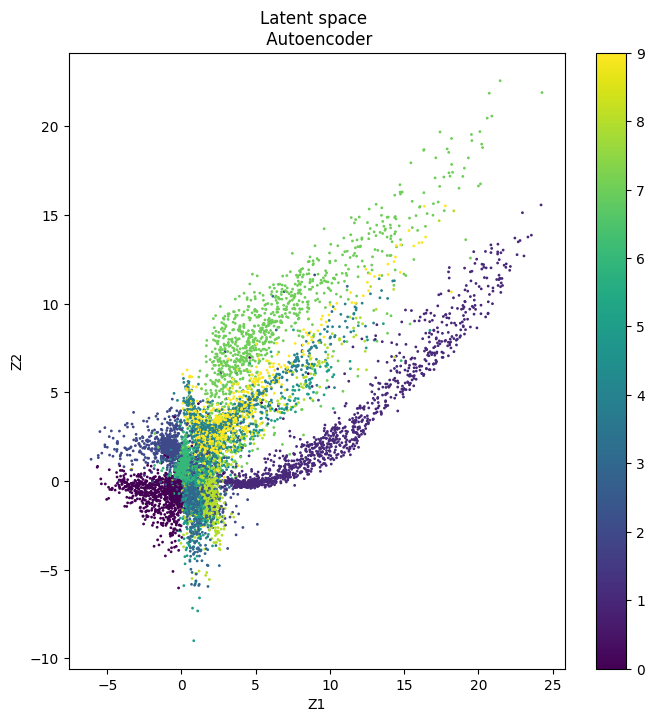

In [ ]:
# Plot the latent  space
f,ax = plt.subplots(1,figsize=(8, 8))

plt.scatter(latent_space[:,0], latent_space[:,1], c=test_labels,  s = 1)
plt.title('Latent space \n Autoencoder')
plt.colorbar()

plt.xlabel('Z1')
plt.ylabel('Z2')
plt.show()

In [ ]:
recostruct_image = np.array(recostruct_image).squeeze()
test_images = np.array(test_images).squeeze()

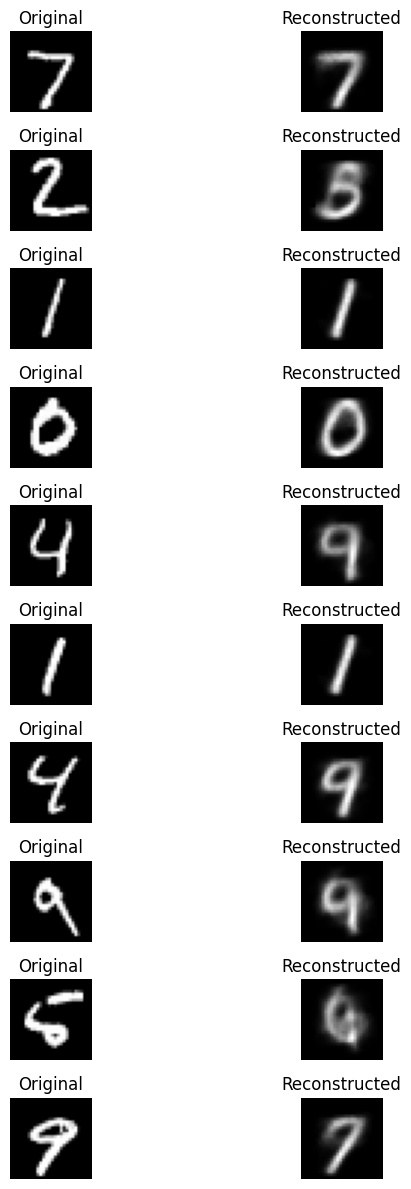

In [ ]:
# Plot the reconstructed images
n_images = 10
fig, axes = plt.subplots(n_images, 2, figsize=(8, 12))
for i in range(n_images):
    # Original Image
    axes[i, 0].imshow(test_images[i].reshape(28,28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')
    # Reconstructed Image
    axes[i, 1].imshow(recostruct_image[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')
plt.tight_layout()
plt.show()

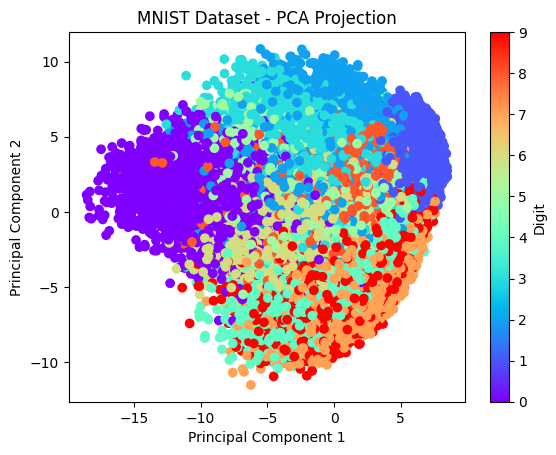

In [ ]:


# Combine all training images into a single tensor
train_images = torch.stack([img for img, _ in trainset], dim=0)
test_images = torch.stack([img for img, _ in testset], dim=0)

# Flatten the images (convert 2D images to 1D vectors)
train_images = train_images.view(train_images.size(0), -1)
test_images = test_images.view(test_images.size(0), -1)

# Calculate the mean of the images
mean = torch.mean(train_images, dim=0)

# Center the data by subtracting the mean from each image
centered_images = train_images - mean

# Calculate the covariance matrix of the centered data
covariance_matrix = torch.mm(centered_images.t(), centered_images) / (centered_images.size(0) - 1)

# Perform eigendecomposition of the covariance matrix
eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)

# Sort the eigenvalues in descending order and sort the corresponding eigenvectors accordingly
eigenvalues, indices = torch.sort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, indices]

# Choose the top k eigenvectors (principal components)
k = 2
top_eigenvectors = eigenvectors[:, :k]

# Project the centered data onto the top k eigenvectors
projected_data = torch.mm(centered_images, top_eigenvectors)

# Plot the projected data
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=trainset.targets, cmap='rainbow')
plt.colorbar(label='Digit')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Dataset - PCA Projection')
plt.show()

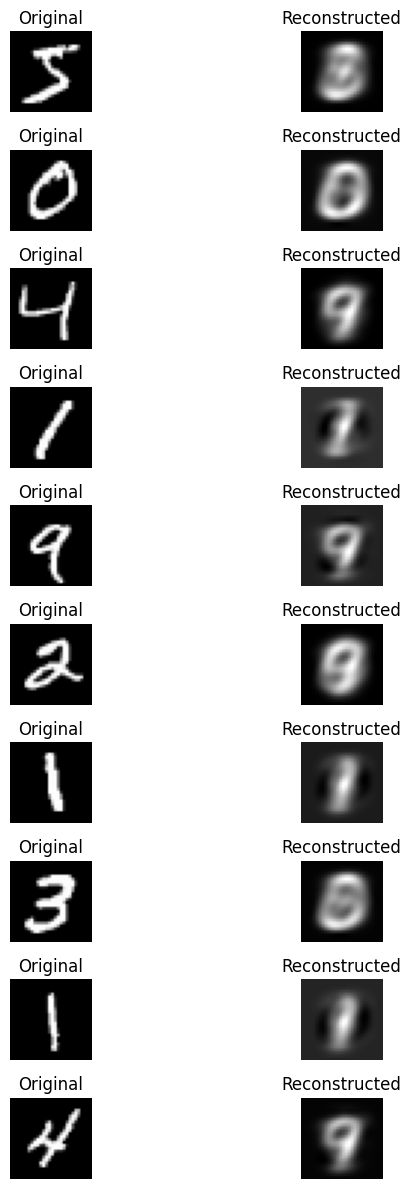

In [ ]:
# Perform inverse transformation to obtain reconstructed data
reconstructed_data = torch.mm(projected_data, top_eigenvectors.t()) + mean

# Reshape the reconstructed data to the original image shape
reconstructed_data = reconstructed_data.view(-1, 28, 28)

# Plot the reconstructed images
n_images = 10
fig, axes = plt.subplots(n_images, 2, figsize=(8, 12))
for i in range(n_images):
    # Original Image
    axes[i, 0].imshow(train_images[i].view(28, 28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')
    # Reconstructed Image
    axes[i, 1].imshow(reconstructed_data[i].detach().numpy(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')
plt.tight_layout()
plt.show()